# **Grasping Siamese Mask R-CNN - Evaluating on the OCID Grasp Dataset**

This notebook provides a demonstration on how to evaluate the Grasping Siamese Mask R-CNN (GSMR-CNN) model on the __[OCID grasp](https://github.com/stefan-ainetter/grasp_det_seg_cnn)__ dataset. The model is evaluated using the __[detection evaluation metrics](https://cocodataset.org/#detection-eval)__ used by COCO, which calculates the average precision and recall at different Intersection over Union (IoU) thresholds (averaged, 0.50, 0.75), object scales (small, medium, large) and maximum amount of detections (1, 10, 100). To evaluate the grasp detection component we calculate grasp accuracy by considering a predicted grasp as successful if for a single ground-truth grasp it has an angle difference within 30° and an IoU score > 25%. Using the same COCO metrics, grasp accuracy is evaluated for both detection and segmentation tasks, which use the bounding box and mask respectively in IoU calculation to determine true positives.

* Before running this folder, make sure to set the variables `DATASET_PATH` and `ANNOTATIONS_PATH` to the directory paths of the OCID grasp dataset and the folder where the COCO-formatted annotations of the OCID grasp dataset were placed. Note that if you do not have the annotations, it is important you ran the `generate_COCO.py` file to generate COCO-formatted annotations before running this code as specified in the `ReadMe` file. The `DATA_SPLIT` variable determines whether the model will be evaluated using an object-wise split or image-wise split. The `MODEL_NAME` variable should be the path to specify path to model relative to the `cfg.CHECKPOINTS_DIR` directory. It should also be mentioned that the `DETECTION_MIN_CONFIDENCE` configuration parameter in the evaluation config can be altered. For the image-wise model a value of 0.9 was used and for the object-wise a value of 0.7 was used.

In [1]:

# ignore FutureWarnings and Tensorflow warnings
import warnings
import os
warnings.filterwarnings("ignore", message=r"Passing", category=FutureWarning)
import tensorflow as tf

# add paths to all libraries
import sys
sys.path.append('libraries/')
sys.path.append('libraries/Mask_RCNN') 
sys.path.append('libraries/Siamese_Mask_RCNN') 
sys.path.append('gsmrcnn/')

import model as gsmrcnn_model
import config as gsmrcnn_config
import utils as gsmrcnn_utils

from sklearn.model_selection import train_test_split
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt

%matplotlib inline

config = gsmrcnn_config.OCIDConfigEvaluation()

DATASET_PATH = 'data/OCID_grasp/'
ANNOTATIONS_PATH = 'data/'
DATA_SPLIT = 'image' # specify if 'object' split or 'image' split
MODEL_NAME = f'gsmrcnn_{DATA_SPLIT}_0025.h5' # specify path to model from cfg.CHECKPOINTS_DIR

Using TensorFlow backend.


## **Dataset**

Similar to the training notebook, the code in this section loads and prepares the dataset for training. It also selects which object classes will be used for training and testing the model. Note that certain object classes were excluded from both training and testing set because they were missing grasp annotations mainly due to them being large objects (e.g. keyboard).

In [2]:
ignore_classes = [5, 7, 11, 12, 16, 17] # exclude classes due to abundant missing grasps...
test_classes = np.array([i for i in range(1,32) if i not in ignore_classes])

# for object-wise split
if DATA_SPLIT == 'object':
    _, test_classes = train_test_split(test_classes, test_size=0.30, random_state=10)
print(f"[INFO] Loading OCID dataset on an {DATA_SPLIT}-wise split.")

# load test dataset
coco_val = gsmrcnn_utils.OCIDDataset()
coco_object = coco_val.load_coco(os.path.join(ANNOTATIONS_PATH, 'validation_annotations.json'), DATASET_PATH, return_coco=True)
coco_val.prepare()
coco_val.build_indices() # creates lists mapping object classes ids to image ids and vice versa
coco_val.ACTIVE_CLASSES = test_classes

print("[INFO] Number of test images:", len(coco_val.image_category_index))

[INFO] Loading OCID dataset on an image-wise split.
loading annotations into memory...
Done (t=0.42s)
creating index...
index created!
[INFO] Number of test images: 352


## **Model**

The code below is used to construct the GSMR-CNN model and load the weights obtained from training.

In [3]:
# load the model (GSM-RCNN) with checkpoints
def load_model():
    checkpoint = os.path.join(config.CHECKPOINT_DIR, MODEL_NAME)
    model = gsmrcnn_model.GraspingSiameseMaskRCNN(mode="inference", model_dir=config.CHECKPOINT_DIR, config=config)
    model.load_checkpoint(checkpoint)
    print("[INFO] Loaded model (GSMR-CNN).")
    return model

model = load_model()

loading models/gsmrcnn_image_0025.h5 ...
starting from epoch 25
[INFO] Loaded model (GSMR-CNN).


## **Getting COCO Results**

Due to the inherent randomness of the target image generation, results may slightly differ when running the evaluation script. Hence, in the script below we calculate COCO metrics **three** times for detection and segmentation and append the results to a list. The subsequent script then averages the results.

* Note that the output below is output obtained from the terminal when evaluating one of the models during experimentations.

In [4]:
print(f'[INFO] Evaluating GSMR-CNN model 3 times on {DATA_SPLIT}-wise split...')

bbox_res, seg_res = [], []
for run in range(3):
    res = gsmrcnn_utils.evaluate_dataset(model, coco_val, coco_object, eval_type=["bbox", "segm"], 
                     dataset_type='coco', limit=0, image_ids=None, 
                     class_index=test_classes-1, verbose=2, return_results=True)
    bbox_res.append(res[0])
    seg_res.append(res[1])

[INFO] Evaluating GSMR-CNN model 3 times on object-wise split...
Processing image 0/352 ...
Processing image 10/352 ...
Processing image 20/352 ...
Processing image 30/352 ...
Processing image 40/352 ...
Processing image 50/352 ...
Processing image 60/352 ...
Processing image 70/352 ...
Processing image 80/352 ...
Processing image 90/352 ...
Processing image 100/352 ...
Processing image 110/352 ...
Processing image 120/352 ...
Processing image 130/352 ...
Processing image 140/352 ...
Processing image 150/352 ...
Processing image 160/352 ...
Processing image 170/352 ...
Processing image 180/352 ...
Processing image 190/352 ...
Processing image 200/352 ...
Processing image 210/352 ...
Processing image 220/352 ...
Processing image 230/352 ...
Processing image 240/352 ...
Processing image 250/352 ...
Processing image 260/352 ...
Processing image 270/352 ...
Processing image 280/352 ...
Processing image 290/352 ...
Processing image 300/352 ...
Processing image 310/352 ...
Processing image 3

In [ ]:
def print_results(p, mean_g, mean_s, ap=1, iouThr=None, areaRng='all', maxDets=100):
    iStr = ' {:<18} {} @[ IoU={:<9} | area={:>6s} | maxDets={:>3d} ] = {:0.3f} | grasp={:0.3f}'
    titleStr = 'Average Precision' if ap == 1 else 'Average Recall'
    typeStr = '(AP)' if ap == 1 else '(AR)'
    iouStr = '{:0.2f}:{:0.2f}'.format(p.iouThrs[0], p.iouThrs[-1]) \
        if iouThr is None else '{:0.2f}'.format(iouThr)
    print(iStr.format(titleStr, typeStr, iouStr, areaRng, maxDets, mean_s, mean_g))

def store_results(params, mean_s, mean_g):
    stats = np.zeros((12,2))
    stats[0] = print_results(params, mean_g[0], mean_s[0], 1)
    stats[1] = print_results(params, mean_g[1], mean_s[1], 1, iouThr=.5, maxDets=params.maxDets[2])
    stats[2] = print_results(params, mean_g[2], mean_s[2], 1, iouThr=.75, maxDets=params.maxDets[2])
    stats[3] = print_results(params, mean_g[3], mean_s[3], 1, areaRng='small', maxDets=params.maxDets[2])
    stats[4] = print_results(params, mean_g[4], mean_s[4], 1, areaRng='medium', maxDets=params.maxDets[2])
    stats[5] = print_results(params, mean_g[5], mean_s[5], 1, areaRng='large', maxDets=params.maxDets[2])
    stats[6] = print_results(params, mean_g[6], mean_s[6], 0, maxDets=params.maxDets[0])
    stats[7] = print_results(params, mean_g[7], mean_s[7], 0, maxDets=params.maxDets[1])
    stats[8] = print_results(params, mean_g[8], mean_s[8], 0, maxDets=params.maxDets[2])
    stats[9] = print_results(params, mean_g[9], mean_s[9], 0, areaRng='small', maxDets=params.maxDets[2])
    stats[10] = print_results(params, mean_g[10], mean_s[10], 0, areaRng='medium', maxDets=params.maxDets[2])
    stats[11] = print_results(params, mean_g[11], mean_s[11], 0, areaRng='large', maxDets=params.maxDets[2])
    return stats


print("[INFO] Printing average 'bbox' results...")
current_res = bbox_res
det_results = np.zeros((12,3))
grasp_results = np.zeros((12,3))
for i in range(3):
    for j in range(12):
        det_results[j][i] = current_res[i].stats[j][0]
        grasp_results[j][i] = current_res[i].stats[j][1]
avg_det_results = np.mean(det_results, axis=1)
avg_grasp_results = np.mean(grasp_results, axis=1)
avg_bbox_res = store_results(bbox_res[0].params, avg_det_results, avg_grasp_results)
# np.save(f"avg_bbox_res_{DATA_SPLIT}.npy", avg_bbox_res) - uncomment to save results

print("[INFO] Printing average 'segm' results...")
current_res = seg_res
det_results = np.zeros((12,3))
grasp_results = np.zeros((12,3))
for i in range(3):
    for j in range(12):
        det_results[j][i] = current_res[i].stats[j][0]
        grasp_results[j][i] = current_res[i].stats[j][1]
avg_det_results = np.mean(det_results, axis=1)
avg_grasp_results = np.mean(grasp_results, axis=1)
avg_segm_res = store_results(bbox_res[0].params, avg_det_results, avg_grasp_results)
# np.save(f"avg_segm_res_{DATA_SPLIT}.npy", avg_segm_res) - uncomment to save results

[INFO] Printing average 'bbox' results...
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526 | grasp=0.919
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.707 | grasp=0.913
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.673 | grasp=0.919
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.371 | grasp=0.871
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.535 | grasp=0.925
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540 | grasp=0.706
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.501 | grasp=0.915
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.675 | grasp=0.919
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.675 | grasp=0.919
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.374 | grasp=0.871
 Average Recall   

## **Visualizing Predictions**

The scripts below provide a demonstration on how to visualize the predictions of the model.

In [10]:
print("Test Classes:", test_classes) # display test class IDs to choose from (different for image-wise and object-wise)

Test Classes: [ 1  2  3  4  6  8  9 10 13 14 15 18 19 20 21 22 23 24 25 26 27 28 29 30
 31]


[INFO] Image ID: 230
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  249.00000  int32
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  249.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


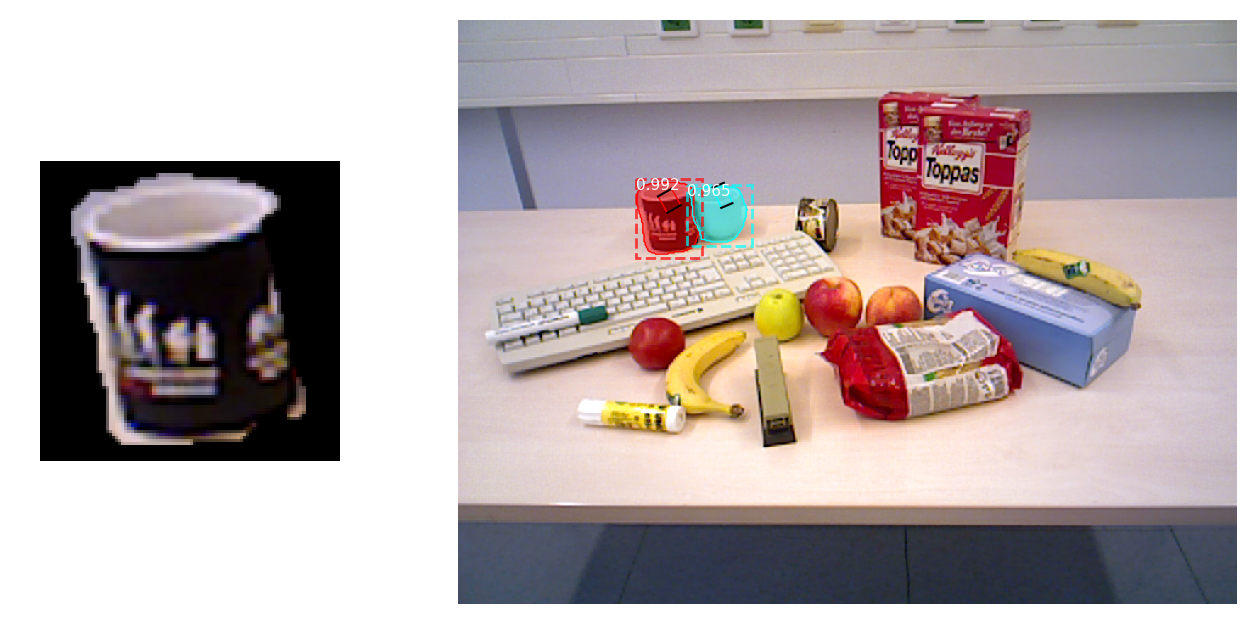

In [8]:
# Select random class ID and an image with the ID
category = 8
image_id = np.random.choice(coco_val.category_image_index[category])
print(f"[INFO] Image ID: {image_id}")
# Load target image
target = gsmrcnn_utils.get_one_target(category, coco_val, config,  image_id=image_id, apply_mask=True)
# Load scene image
image = coco_val.load_image(image_id)

# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]

# Display result
gsmrcnn_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['grasps'], r['scores'])
plt.show()

[INFO] Image ID: 3
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
target                   shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 640, 640, 3)      min: -123.70000  max:  151.10000  float64
molded_targets           shape: (1, 1, 96, 96, 3)     min:    0.00000  max:  255.00000  int32
anchors                  shape: (1, 102300, 4)        min:   -0.56657  max:    1.46641  float32


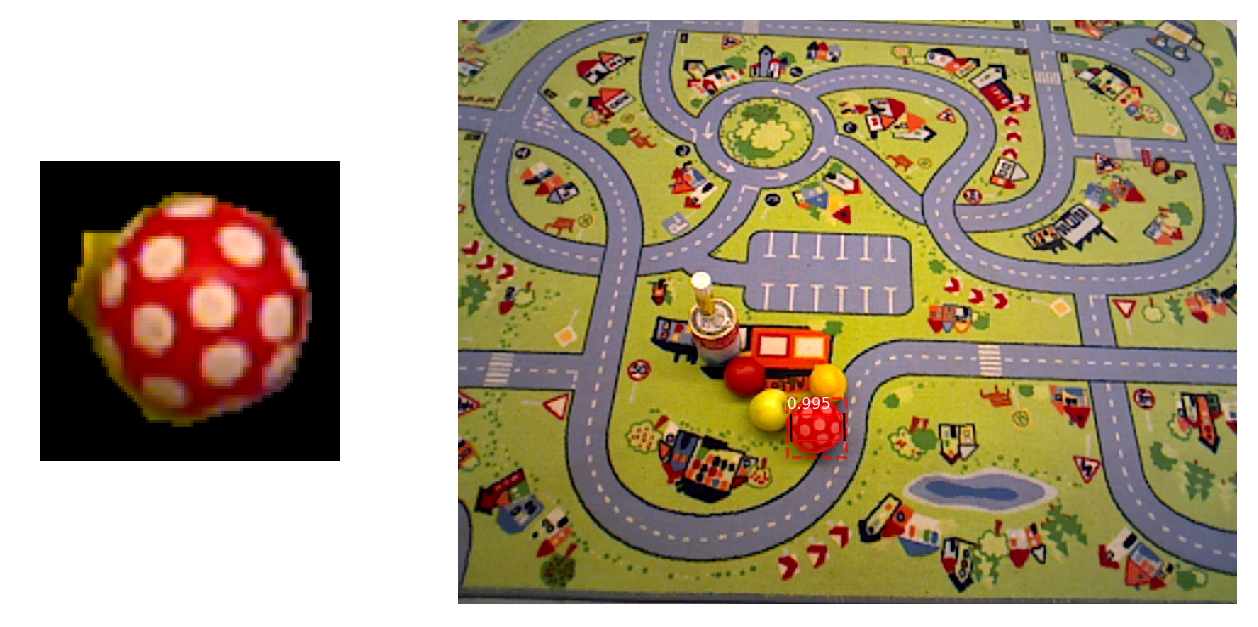

In [11]:
# Select random class ID and an image with the ID
category = 2
image_id = np.random.choice(coco_val.category_image_index[category])
print(f"[INFO] Image ID: {image_id}")
# Load target image
target = gsmrcnn_utils.get_one_target(category, coco_val, config,  image_id=image_id, apply_mask=True)
# Load scene image
image = coco_val.load_image(image_id)

# Run detection
results = model.detect([[target]], [image], verbose=1)
r = results[0]

# Display result
gsmrcnn_utils.display_results(target, image, r['rois'], r['masks'], r['class_ids'], r['grasps'], r['scores'])
plt.show()